# Testing the assumptions of linear regression

Linear regressions is commonly used from forecasting height of children to estimating stock $\beta$.  
Its popularity is supported by its simplicity and well-studied properties.  
This notebooks focuses on testing the assumptions of linear regression with statistical tests and plots.

> *Data set includes returns of Istanbul Stock Exchange with seven other international indexes: SP, DAX, FTSE, NIKKEI, BOVESPA, MSCE_EU, MSCI_EM from Jun 5, 2009 to Feb 22, 2011.*  

I train my regressor to forecast ISE 100 returns (now called BIST 100) using ISE 100 and seven other indexes data from the previous business day as independent variables. Data set is vailable here: https://archive.ics.uci.edu/ml/datasets/istanbul+stock+exchange  

More on the topic: http://people.duke.edu/~rnau/testing.htm

<img src="https://upload.wikimedia.org/wikipedia/commons/b/b2/Galton%27s_correlation_diagram_1875.jpg"  width="30%"/>

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.datasets import make_regression

import matplotlib.ticker as ticker

import statsmodels.graphics as smg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

In [2]:
data = pd.read_csv("/.../data_akbilgic.csv")
data.date = pd.to_datetime(data.date)
data.set_index("date", inplace=True, drop=True)
data["ISE_next"] = data.ISE.shift(-1)
data = data[:-1]

In [3]:
data.head()

,ISE,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM,ISE_next
date,,,,,,,,,
2009-01-05,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524,0.031813
2009-01-06,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773,-0.026353
2009-01-07,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015,-0.084716
2009-01-08,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424,0.009658
2009-01-09,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802,-0.042361


In [4]:
train_size = int(len(data.index) * 0.66)

X_train, X_test, y_train, y_test = data.loc[:, data.columns != "ISE_next"].values[
    0:train_size], data.loc[:, data.columns != "ISE_next"].values[
        train_size:], data.loc[:, data.columns == "ISE_next"].values[
            0:train_size], data.loc[:, data.columns == "ISE_next"].values[
                train_size:]

test_dates = data.index[train_size:]

In [5]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [6]:
predictions = reg.predict(X_test)
residuals = predictions - y_test

### Linear relationship between dependent and independent variables

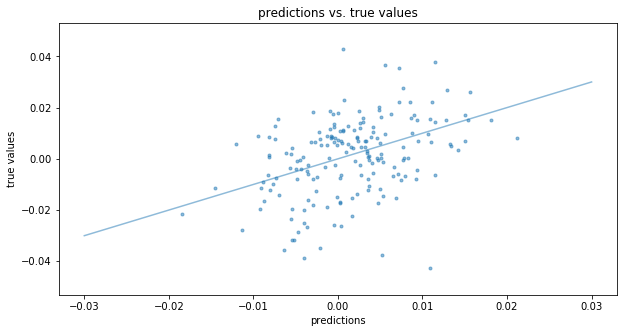

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(predictions, y_test, marker=".", alpha=.5)
ax.plot((-.03, .03), (-.03, .03),alpha=.5)
ax.set_xlabel("predictions")
ax.set_ylabel("true values")
ax.set_title("predictions vs. true values");


Supposed to be symmetrically distributed around the diagonal.

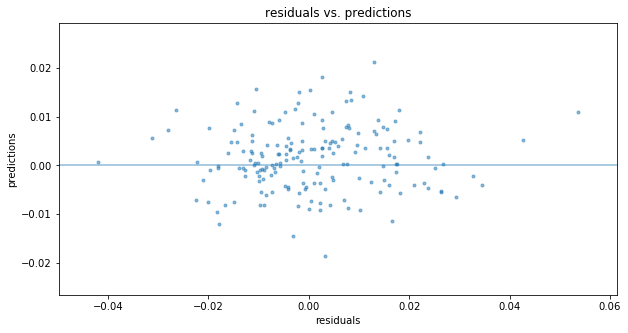

In [8]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(residuals, predictions, marker=".", alpha=.5)
ax.axhline(0, alpha=.5)
ax.set_xlabel("residuals")
ax.set_ylabel("predictions")
ax.set_title("residuals vs. predictions");

Supposed to be symmetrically distributed around a horizontal line.

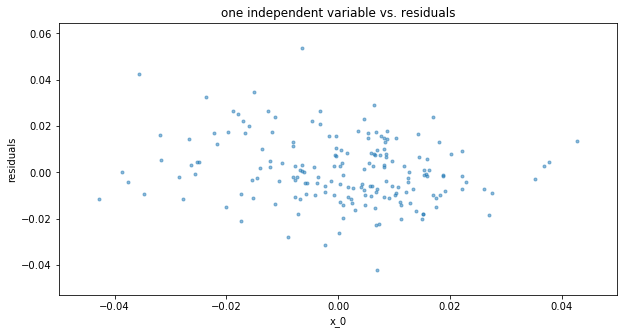

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(X_test.T[0], residuals, marker=".", alpha=.5)
ax.set_xlabel("x_0")
ax.set_ylabel("residuals")
ax.set_title("one independent variable vs. residuals");

Supposed to be a random scatter.

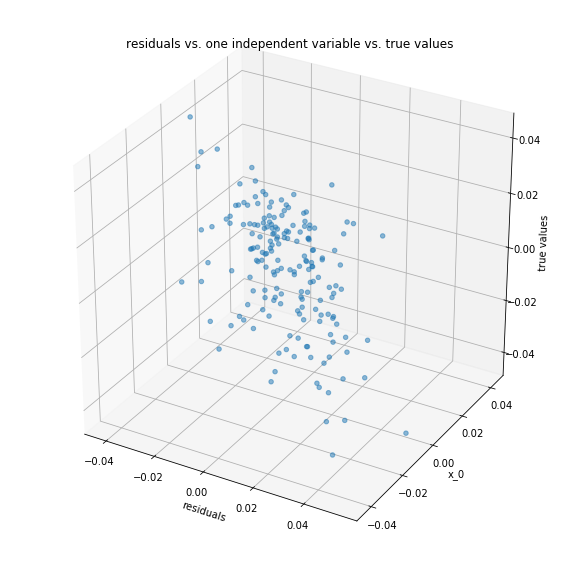

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(residuals, X_test.T[0], y_test, alpha=.5)
ax.set_xlabel('residuals')
ax.set_ylabel('x_0')
ax.set_zlabel('true values')
ax.set_title("residuals vs. one independent variable vs. true values");

Difficult to interpret but sometimes has more obvious meaning.

### Independence of the errors
Commonly considered as less critical for cross-sectional data since autocorrelation is the correlation of a signal with a distance-separated (delayed) copy of that signal. Picking a good metric space is trickier when time is not an option. One solution: do not pick and test against everything (predictions and independent variables).

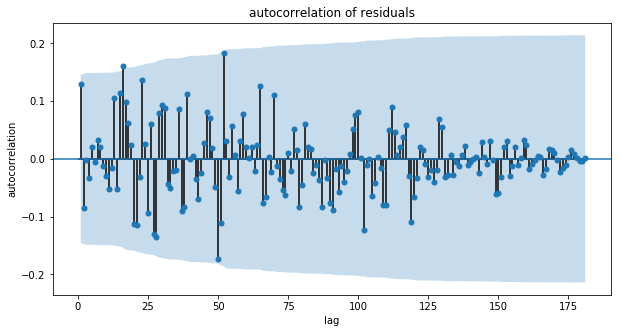

In [11]:
lags = len(y_test) - 1

fig, ax = plt.subplots(figsize=(10, 5))

smg.tsaplots.plot_acf(
    residuals, lags=lags, alpha=.05, use_vlines=True, zero=False, title="", ax=ax)
ax.hlines(0, xmin=0, xmax=lags)
ax.set_xlabel("lag")
ax.set_ylabel("autocorrelation")
ax.set_title("autocorrelation of residuals");

Most of the residual autocorrelations fall within the 95% confidence interval bands around zero.

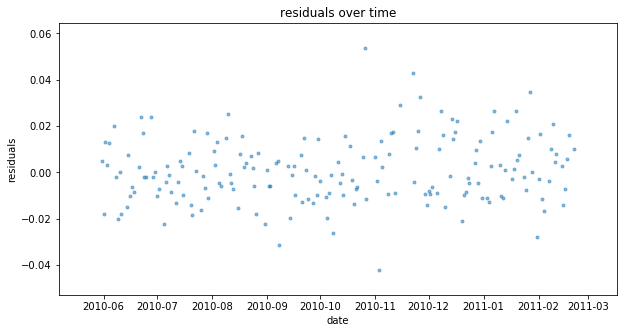

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(test_dates, residuals, marker=".", alpha=.5)
ax.set_xlabel("date")
ax.set_ylabel("residuals")
ax.set_title("residuals over time");

In [13]:
ordered_test = pd.DataFrame(X_test)
ordered_test.insert(loc=len(ordered_test.columns), value=y_test, column="y")
ordered_test.insert(loc=len(ordered_test.columns), value=residuals, column="residuals")

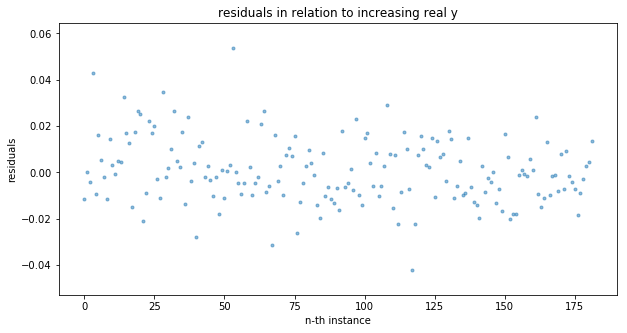

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(ordered_test.sort_values(by="y").reset_index().index, ordered_test.sort_values(by=0).residuals, marker=".", alpha=.5)
ax.set_xlabel("n-th instance")
ax.set_ylabel("residuals")
ax.set_title("residuals in relation to increasing real y");

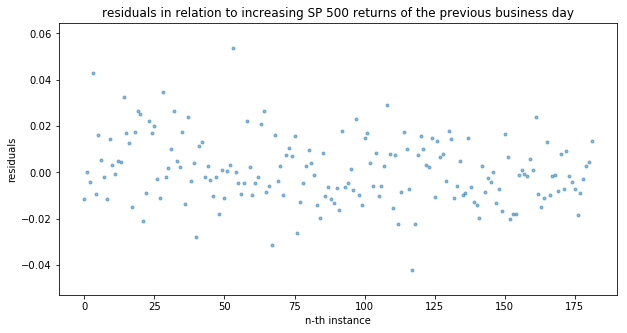

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(ordered_test.sort_values(by=1).reset_index().index, ordered_test.sort_values(by=0).residuals, marker=".", alpha=.5)
ax.set_xlabel("n-th instance")
ax.set_ylabel("residuals")
ax.set_title("residuals in relation to increasing SP 500 returns of the previous business day");

### Normality of the error distribution
Probably not the most critical tests because of low normality expectations (real data rarely has normally distributed errors). Also, other tests are directly related to it (violations of linearity for instance).

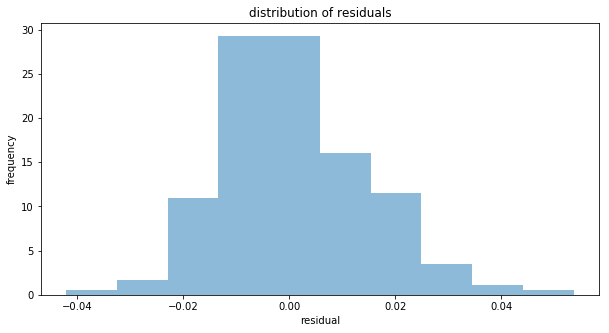

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(residuals, bins=10, alpha=.5, normed=True)
ax.set_xlabel("residual")
ax.set_ylabel("frequency")
ax.set_title("distribution of residuals");

In [17]:
alpha = 0.05
p  = sm.stats.diagnostic.normal_ad(residuals)[1]

print("H0 can be rejected :", str(p < alpha))

H0 can be rejected : [ True]


Not normal according to Anderson-Darling test.

### Homoscedasticity of errors

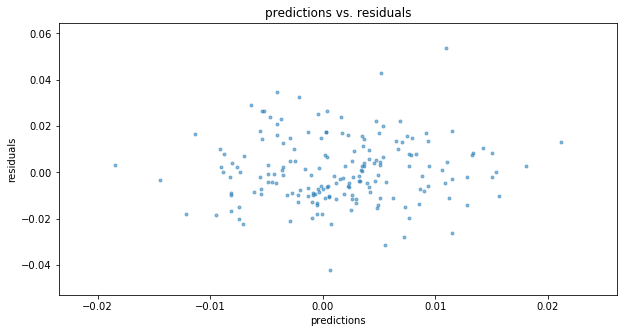

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(predictions, residuals, marker=".", alpha=.5)
ax.set_xlabel("predictions")
ax.set_ylabel("residuals")
ax.set_title("predictions vs. residuals");

The variance of errors seems constant vs. predictions (visually).

In [19]:
alpha = 0.05
p  = sm.stats.diagnostic.het_breuschpagan(residuals, X_test)[3]
print("H0 can be rejected :", str(p < alpha))

H0 can be rejected : False


The variance of errors is constant (versus independent variables) according to Breusch-Pagan Lagrange Multiplier test for heteroskedasticity.